In [1]:
import numpy as np
import pandas as pd

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
import sys
sys.path.append('../')
import util

In [3]:
FILE = '../data/arc_final_des.csv'
# FILE = '../data/arc_final_fin.csv'
# FILE = '../data/arc_final_ms_spec.csv'

data = pd.read_csv(FILE, index_col=0)

data

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
107,0,0,0,0,0,1,1,0,0,0,...,0.870601,-0.485781,0.428391,-0.097812,0.001562,-0.242563,-0.427532,-0.596113,-0.024422,-0.443478
126,0,0,0,0,1,0,1,0,0,0,...,1.750794,-1.013401,0.300976,-0.033139,0.067627,-0.242563,-0.633394,-0.737723,-1.165779,-0.836798
174,0,0,0,0,0,0,0,1,0,0,...,0.032445,-2.425877,-3.359749,-0.152376,-0.054176,-0.242563,-0.829452,-1.870605,-2.584962,-2.311751
177,0,0,0,0,0,1,0,0,0,0,...,0.108736,-2.684755,-4.617587,-0.998939,-0.918961,-0.242563,-0.844156,-2.012215,-1.772042,-2.508411
179,0,0,0,0,0,1,0,0,0,0,...,0.108736,-1.942763,-2.790262,-0.142069,-0.043648,-0.242563,-0.782888,-1.445774,-2.119984,-1.721770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140998267,1,0,1,0,0,1,0,0,0,0,...,0.052427,0.621329,-0.971686,0.947798,1.069679,-0.242563,0.344448,0.678379,-0.439317,0.638154
141266555,0,1,1,0,0,0,0,0,0,0,...,-0.872139,0.654758,-0.722589,0.139547,0.244031,-0.242563,0.410618,0.395159,0.916077,0.441493
142523980,1,0,0,0,1,0,1,0,0,0,...,-1.057710,0.027658,0.386557,-0.922173,-0.840543,-0.242563,-0.167755,0.111938,0.624544,0.048173
144116082,1,0,0,1,1,0,0,0,0,0,...,-0.893362,0.236738,-0.035581,-0.909362,-0.827456,-0.242563,-0.104036,0.961600,0.232845,0.539824


In [4]:
NUM_LABEL_COLS = 12
FEATURE_COLS = data.columns[NUM_LABEL_COLS:]
LABEL_COLS = data.columns[:NUM_LABEL_COLS]
print(FEATURE_COLS)
print(LABEL_COLS)

X = data[FEATURE_COLS].values
y = data[LABEL_COLS].values

X.shape, y.shape

Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
       'nAtom', 'nHeavyAtom', 'nH',
       ...
       'AMW', 'WTPT-1', 'WTPT-2', 'WTPT-3', 'WTPT-4', 'WTPT-5', 'WPATH',
       'WPOL', 'XLogP', 'Zagreb'],
      dtype='object', length=1120)
Index(['Floral', 'Fruity', 'Herbal', 'Green', 'Woody', 'Sweet', 'Balsamic',
       'Earth', 'Spicy', 'Chemical', 'Animalic', 'Nutty'],
      dtype='object')


((2328, 1120), (2328, 12))

In [5]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1862, 1120), (466, 1120), (1862, 12), (466, 12))

In [6]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h1> Hyperbolic </h1>

In [7]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers, manifold):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_out = hnn.HLinear(layer_size, output_size, manifold=manifold)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x


# Define training function
def hyp_train_model(model, train_loader, criterion, optimizer, manifold, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        outputs = model(manifold_inputs)

        loss = criterion(outputs.tensor, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

<h1> EUCLIDEAN </h1>

In [8]:
# Define your MLP model
class EUC_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers):
        super(EUC_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.hidden_fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_hidden_layers)])
        self.fc_out = nn.Linear(layer_size, output_size)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x

# Define training function
def euc_train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [35]:
param_grid = {
    'subset_frac': [1/2,1/3,1/4,1/6,1/8],
    'subset_seed': [42],
    'model_type': ['hyp', 'euc'],
    'num_hidden_layers': [1,2],
    'layer_size': [32,64,128,256,512],
    'lr': [0.01,0.02],
    'weight_decay': [0.002,0.005,0.01,0.02],
    'batch_size': [1024],
    'epochs': [100],
    'curvature': [-1]
}

param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

800

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    # model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    subset_frac, subset_seed, model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (fold_train_indices, fold_val_indices) in enumerate(kf.split(train_X, train_y)):
        print(f'Fold {fold}')

        np.random.seed(subset_seed)
        subset_fold_train_indices = np.random.rand(len(fold_train_indices)).argsort()[:int (len(fold_train_indices)*subset_frac)]

        fold_train_X = train_X[subset_fold_train_indices]
        fold_train_y = train_y[subset_fold_train_indices]
        fold_val_X   = train_X[fold_val_indices]
        fold_val_y   = train_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        if model_type == 'hyp':
            manifold = PoincareBall(c=Curvature(curvature))
        elif model_type == 'euc':
            manifold = None

        if model_type == 'hyp':
            model = HYP_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers,
                            manifold=manifold).to(device)
        elif model_type == 'euc':
            model = EUC_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers).to(device)

        criterion = nn.CrossEntropyLoss()

        if model_type == 'hyp':
            optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif model_type == 'euc':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'loss': {'train': [], 'val': []},
                      'acc': {'train': [], 'val': []},
                      'aps': {'train': [], 'val': []}
                      }

        for epoch in range(epochs):
            if model_type == 'hyp':
                eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))

                acc, aps = util.h_evaluate_acc_aps(model, val_loader, manifold, device)
                eval_stats['acc']['val'].append(acc)
                eval_stats['aps']['val'].append(aps)
            elif model_type == 'euc':
                eval_stats['loss']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))

                acc, aps = util.evaluate_acc_aps(model, val_loader, device)
                eval_stats['acc']['val'].append(acc)
                eval_stats['aps']['val'].append(aps)

        print(eval_stats['acc']['val'])
        print(eval_stats['aps']['val'])
        param_eval_stats.append(eval_stats)

----- Combination 0 -----
('subset_frac', 1) ('subset_seed', 0) ('model_type', 'hyp') ('num_hidden_layers', 1) ('layer_size', 32) ('lr', 0.01) ('weight_decay', 0.002) ('batch_size', 1024) ('epochs', 100) ('curvature', -1)
Fold 0
[0.0, 0.002680965147453083, 0.002680965147453083, 0.002680965147453083, 0.002680965147453083, 0.002680965147453083, 0.005361930294906166, 0.005361930294906166, 0.005361930294906166, 0.00804289544235925, 0.00804289544235925, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.00804289544235925, 0.010723860589812333, 0.013404825737265416, 0.013404825737265416, 0.013404825737265416, 0.013404825737265416, 0.00804289544235925, 0.00804289544235925, 0.00804289544235925, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0.010723860589812333, 0

KeyboardInterrupt: 

In [ ]:
acc_values = np.array([s['acc']['val'] for s in param_eval_stats])
aps_values = np.array([s['aps']['val'] for s in param_eval_stats])

<h1>BEST MODELS</h1>

In [86]:
# meanAPS = 0.476
hyp_des = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.01,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 50,
    'curvature': -1
}

# meanAPS = 0.444
euc_des = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 256,
    'lr': 0.01,
    'weight_decay': 0.01,
    'batch_size': 1024,
    'epochs': 50,
    'curvature': -1
}


# meanAPS = 0.470
hyp_fin = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.01,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}

# meanAPS = 0.456
euc_fin = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 128,
    'lr': 0.01,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}


# meanAPS = 0.355
hyp_ms_spec = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.02,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}

# meanAPS = 0.321
euc_ms_spec = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.01,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}

In [87]:
test_stats = []

In [101]:
params = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.01,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params.values()

fold_train_X = train_X
fold_train_y = train_y
fold_val_X   = test_X
fold_val_y   = test_y

train_dataset = CustomDataset(fold_train_X, fold_train_y)
val_dataset = CustomDataset(fold_val_X, fold_val_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

if model_type == 'hyp':
    manifold = PoincareBall(c=Curvature(curvature))
elif model_type == 'euc':
    manifold = None

if model_type == 'hyp':
    model = HYP_MLP(input_size=len(FEATURE_COLS),
                    output_size=len(LABEL_COLS),
                    layer_size=layer_size,
                    num_hidden_layers=num_hidden_layers,
                    manifold=manifold).to(device)
elif model_type == 'euc':
    model = EUC_MLP(input_size=len(FEATURE_COLS),
                    output_size=len(LABEL_COLS),
                    layer_size=layer_size,
                    num_hidden_layers=num_hidden_layers).to(device)

criterion = nn.CrossEntropyLoss()

if model_type == 'hyp':
    optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif model_type == 'euc':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

eval_stats = {'loss': {'train': [], 'val': []},
                'acc': {'train': [], 'val': []},
                'aps': {'train': [], 'val': []}
                }

for epoch in range(epochs):
    if model_type == 'hyp':
        eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))

        acc, aps = util.h_evaluate_acc_aps(model, val_loader, manifold, device)
        eval_stats['acc']['val'].append(acc)
        eval_stats['aps']['val'].append(aps)
    elif model_type == 'euc':
        eval_stats['loss']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))

        acc, aps = util.evaluate_acc_aps(model, val_loader, device)
        eval_stats['acc']['val'].append(acc)
        eval_stats['aps']['val'].append(aps)

print(eval_stats['acc']['val'])
print(eval_stats['aps']['val'])
# test_stats.append(eval_stats)
test_stats.append(np.array(eval_stats['aps']['val']))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.0, 0.004784688995215311, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.004784688995215311, 0.0, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.0, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.0, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.0, 0.0, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004784688995215311, 0.009569377990430622, 0.0, 0.009569377990430622, 0.0, 0.0, 0.009569377990430622, 0.0, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.0, 0.009569377990430622, 0.0, 0.0, 0.004784688995215311, 0.004784688995215311, 0.00478

In [103]:
test_stats[-1].shape

(100, 12)

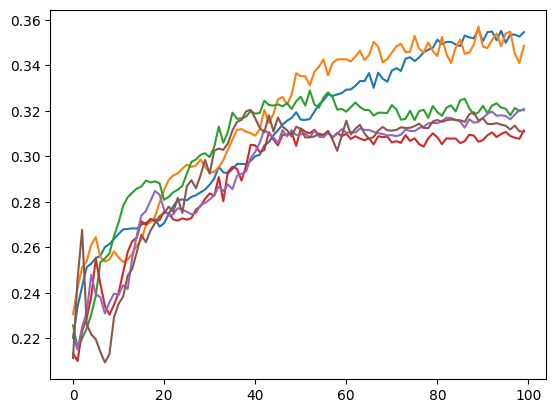

In [104]:
import matplotlib.pyplot as plt

for stats in test_stats:
    plt.plot(stats.mean(axis=1))

plt.show()

In [105]:
for stats in test_stats:
    print(stats.mean(axis=1)[49], stats.mean(axis=1)[-1])

0.3193882871123193 0.35459722616522904
0.336504786827805 0.3486356550147906
0.3242186407979791 0.32079709858598016
0.3045959190663067 0.3113074233529866
0.30934958302218224 0.32029402270964674
0.3130542280173884 0.3108727872313602
